<a href="https://colab.research.google.com/github/dpenagosa/TAREASMINERIA/blob/main/Entrega_2_2_multivariateNormal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conceptos básicos de clasificación Bayesiana

- Se presentan los conceptos básicos de detección y clasificación bajo principios probabilísticos y Bayesianos.



# Principio básicos de detección y clasificación.

- La regla básica de [Neyman Person](https://en.wikipedia.org/wiki/Neyman%E2%80%93Pearson_lemma) plantea la relación básica de detección bajo la hipótesis no nula $A$ y la hipotesis nula $B$, dada una secuencia de datos $\mathbf{x}\in\mathbb{R}^P,$ según:

$$\frac{P(\mathbf{x}|A)}{P(\mathbf{x}|B)} > \xi \tag 1$$ 

donde el umbral $\xi\in \mathbb{R}$ se puede estimar a partir de un nivel de significancia dado $\alpha \in [0,1].$

- La regla de detección se puede extender mediante el [teorema de Bayes](https://en.wikipedia.org/wiki/Bayesian_inference):

$$\frac{P(\mathbf{x}|A)}{P(\mathbf{x}|B)} > \frac{P(B)}{P(A)}  = \xi \tag 2$$
En este caso se puede entender como un detector de máximo a-posteriori (MAP). 

- Si se fija el umbral $\xi=0$, se puede plantear la regla de detección Bayesian en (2) a partir de la construcción de una frontera en 0, según:  

**Nota:** Para el caso $P(A) = P(B)$ el MAP se convierte en un detector de máxima verosimilitud, maximum likelihood (ML).

$$P(\mathbf{x}|A)P(A)-P(\mathbf{x}|B)P(B)>0 \tag 3$$

- Recuerde que el teorema de Bayes establece que $P(\mathbf{x},A)=P(A,\mathbf{x})$, y $P(\mathbf{x}|A)P(A)=P(A|\mathbf{x})P(\mathbf{x}),$ entonces: 

$$P(A|\mathbf{x})=\frac{P(\mathbf{x}|A)P(A)}{P(\mathbf{x})} \tag 4$$

donde $P(A|\mathbf{x})$ es el posterior, $P(\mathbf{x}|A)$ es la verosimilitud, $P(A)$ es el prior y $P(\mathbf{x})$ es la evidencia.

- La desigualdad planteada en (3) pretende cuantificar que tan bien es explicado o modelado el vector $\mathbf{x}$ por la condición $A$ o por la condición $B$ (clases o grupos en el contexto de clasificación binaria).

- **Distintos modelos de clasificación se pueden obtener desde la aproximación de los estimadores de probabilidad en (3)**.






# Clasificador Bayesiano ingenuo - Naïve Bayes

- Asume que los $P$ atributos son independientes.

 $$ p(\mathbf{x},A) = p(\mathbf{x}|A)p(A)=\prod_{j=1}^Pp(x_j|A)p(A)$$

 - Por ende, la función de predicción se puede definir como:

 $$\hat{y} = f(\mathbf{x}) =  \arg\max_c \prod_{j=1}^Pp(x_j|A_c)p(A_c)$$

 - Los priors de las clases $p(A_c)$ se pueden fijar o estimar por conteo $\hat{p}(A_c)= MuestrasEnA_c/N$.

 - Respecto a las verosimilitudes, generalmente se asumen como [Gaussianas univariadas](https://en.wikipedia.org/wiki/Normal_distribution) o mediante estimadores no paramétricos de Parzen - [kernel density estimator](https://en.wikipedia.org/wiki/Kernel_density_estimation). Sin embargo, algunas otras distribuciones también son utilizadas (ver [https://scikit-learn.org/stable/modules/naive_bayes.html](https://scikit-learn.org/stable/modules/naive_bayes.html))
  - GuassianNB: $\hat{p}(x_j|A_c)=\mathcal{N}(x_j|\mu_{j,c},\sigma^2_{j,c})$
  - Parzen: $\hat{p}(x_j|A_c)=\frac{1}{N_c}\sum_{\forall x'_j | y_j=A_c }\kappa(x_j-x'_j)$, donde $\kappa(\cdot)$ generalmente se impone como una función rbf.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
import numpy as np
from scipy.stats import multivariate_normal as mn
import warnings
warnings.filterwarnings("ignore")

#función para muestrear problema biclase desde Gaussianas multivariadas
def my_biclass_gm(mu1,Sigma1,mu2,Sigma2,N1=100,N2=100):
  pdf1 = mn(mu1, Sigma1) # objeto scipy para evaluar o muestrear gaussiana multivariada
  pdf2 = mn(mu2,Sigma2)
  X = np.r_[pdf1.rvs(size=N1),pdf2.rvs(size=N2)] # muestrear de las dos pdfs los datos (NO hacer esto-los datos X los ingresa el usuario)
  y = np.r_[-1.0*np.ones((N1,1)),np.ones((N2,1))] #etiquetas, -1 y +1 para el problema binario
  return X, y

#función para graficar frontera de decisión
def my_plot_biclassifier(model,X,y,levels=15,h = 0.01,score_type="decision_function"): #h:paso en el mesh
    plt.scatter(X[(y==-1).ravel(),0],X[(y==-1).ravel(),1],c='r',marker='o')
    plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],c='b',marker='x')
    plt.xlabel('atributo 1')
    plt.ylabel('atributo 2')
    
    #rangos de análisis
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))#definir rejilla sobre espacio 2D

    # evaluar decision function o predict proba del modelo
    if score_type == "predict_proba":
      if hasattr(model, "predict_proba"):
          Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]#se define clase en columna 1 como target
      else:
        Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
      if hasattr(model, "decision_function"):
          Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])#se define clase en columna 1 como target
      else:
        Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]

        
    # graficar resultado en color
    Z = Z.reshape(xx.shape)
    pb = plt.gca().contourf(xx, yy, Z, levels=levels,cmap=plt.cm.RdBu, alpha=0.3)    
    cbar_ax = plt.gcf().add_axes([1.01, 0, 0.025, 0.95])
    plt.gcf().colorbar(pb,extend='both', cax=cbar_ax)    

    return 

- Se define un conjunto de datos bi-clase mediante Gaussianas multivariadas.

In [ ]:
#definir medias y cov de las clases
mu1 = np.array([-3,-2])
mu2 = np.array([0,2])
Sigma1 = np.array([[2,0.8],[0.8,1]])
Sigma2 = np.array([[1.5,0.6],[0.6,3]])
X,y = my_biclass_gm(mu1,Sigma1,mu2,Sigma2)


- Se entrena el modelo utilizando sklearn [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)

- Se grafican las probabilidades por atributo utilizando los parámetros de media y varianza aprendidos por el modelo.

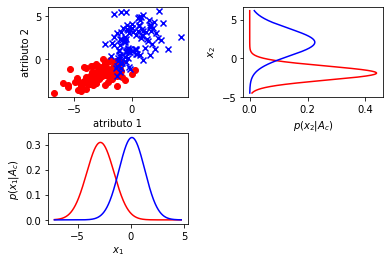

In [ ]:
#crear modelo Bayes Ingenuo
from sklearn.naive_bayes import GaussianNB
cla = GaussianNB()
cla.fit(X,y) #ajustar modelo
ye = cla.predict(X)#estimar etiquetas
#graficar datos y pdf estimadas
plt.subplot(221)
plt.scatter(X[(y==-1).ravel(),0],X[(y==-1).ravel(),1],c='r',marker='o')
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],c='b',marker='x')
plt.xlabel('atributo 1')
plt.ylabel('atributo 2')

#pdfs
var_ = cla.sigma_ #varianzas calculadas n_clases x n_atributos
mu_= cla.theta_#medias calculadas n_clases x n_atributos
mn11 =  mn(mu_[0,0], var_[0,0]) # 
mn21 =  mn(mu_[1,0], var_[1,0]) # 
mn12 =  mn(mu_[0,1], var_[0,1]) # 
mn22 =  mn(mu_[1,1], var_[1,1]) # 
#rejeilla valores
xx = np.arange(X[:,0].min()-0.5,X[:,0].max()+0.5,0.01)
yy = np.arange(X[:,1].min()-0.5,X[:,1].max()+0.5,0.01)
#evaluar pdfs
pdf11 = mn11.pdf(xx)
pdf21 = mn21.pdf(xx)
pdf12 = mn12.pdf(yy)
pdf22 = mn22.pdf(yy)

plt.subplot(222)
plt.plot(pdf12,yy,'r')
plt.plot(pdf22,yy,'b')
plt.ylabel('$x_2$')
plt.xlabel('$p(x_2|A_c)$')

plt.subplot(223)
plt.plot(xx,pdf11,'r')
plt.plot(xx,pdf21,'b')
plt.xlabel('$x_1$')
plt.ylabel('$p(x_1|A_c)$')
plt.subplots_adjust(wspace=0.4,hspace=0.4)


- Se grafica la frontera de decisión según el score del clasificador respecto a la clase azul.

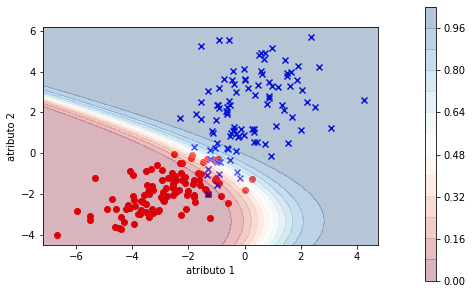

In [ ]:
my_plot_biclassifier(cla,X,y) #graficar contornos del modelo

# Clasificador Bayesiano mediante Gaussiana multivariada.
- Para codificar la dependencia entre atributos, se utiilza una Gaussiana multivariada.

- Se asume un problema bi-clase, con verosimilitudes estimadas según una Gaussiana multivariada#

$$\hat{p}(\mathbf{x}|A_c) = \frac{1}{2\pi^{P/2}|\Sigma_c|^{1/2}}\exp\left(\frac{-(\mathbf{x}-\mathbf{\mu})^\top\Sigma_c^{-1}(\mathbf{x}-\mathbf{\mu})}{2}\right)$$

donde la notación $|\Sigma_c|$ se refiere al determinante de la matriz de covarianza y $\mathbf{x},\mathbf{x}\in\mathbb{R}^P$ y $\mathbf{\Sigma}\in \mathbb{R}^{P\times P}$.

-Aplicando logaritmo a la regla de detección Bayesiana:

$$\log\left(\frac{P(\mathbf{x}|A)}{P(\mathbf{x}|B)}\right) >\log\left( \frac{P(B)}{P(A)}\right)$$

y reemplazando el estimador de las verosimilitudes por Gaussiana multivariada, se obtiene un nuevo score de decisión (frontera) para el caso de clasificación binaria, según:

$$f(\mathbf{x})= 0.5\left((\mathbf{x}-\mathbf{\mu}_B)^\top\mathbf{\Sigma}^{-1}_B(\mathbf{x}-\mathbf{\mu}_B)-(\mathbf{x}-\mathbf{\mu}_A)^\top\mathbf{\Sigma}_A^{-1}(\mathbf{x}-\mathbf{\mu}_A) +\log(|\mathbf{\Sigma}_B|)-\log(|\mathbf{\Sigma}_A|)\right) +\cdots\\ \cdots+\log(p(A))-\log(p(B))$$

- Si $f(\mathbf{x})\geq0$ $\hat{y}=A$, en otro caso $\hat{y}=B.$

- Note que la frontera depende de la [distancia de Mahalanobis](https://es.wikipedia.org/wiki/Distancia_de_Mahalanobis) entre la muestra y las medias de cada una de las clases.

- El clasificador Bayesiano mediante Gaussiana multivariada también se puede entender como un clasificador cuadrático desde el punto de vista geométrico.

# Ejercicio 1

- Demuestre el resultado de la expresión de la frontera de decisión para el clasificador Bayesiano mediante Gaussiana multivariada (Ver [documento de apoyo](https://github.com/amalvarezme/AnaliticaDatos/blob/master/3_Clasificacion/otros/clasificadoresBayes.pdf)).

[RESPUESTA 1 en pdf](https://github.com/dpenagosa/TAREASMINERIA/blob/main/Frontera.pdf)




- Se presente el resultado del [clasificador Bayesiano cuadrático](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html) (Gaussiana multivariada) en sklearn sobre los datos de prueba utilizados anteriormente.

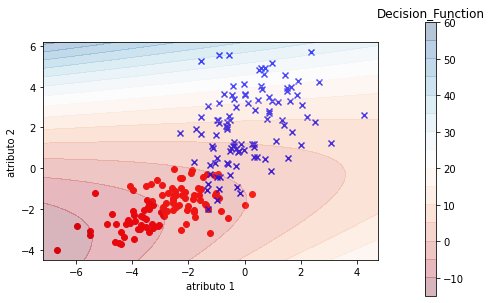

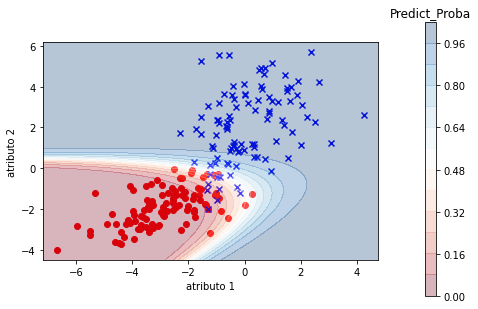

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
cla = QuadraticDiscriminantAnalysis(store_covariance=True) #se obliga a guardar las matrices de cov
cla.fit(X,y)
my_plot_biclassifier(cla,X,y)
plt.title('Decision_Function')
plt.show()

my_plot_biclassifier(cla,X,y,score_type='predict_proba')
plt.title('Predict_Proba')
plt.show()

**Nota**: dada su interpretabilidad geométrica, se presenta el score en término de la distancia a la frontera de decisión y de la probabilidad de clase. 

# Ejercicio 2

- Grafique las matrices de covarianza estimadas por clasificador y discuta sobre las colinealidades encontradas (ver método `covariance_`).

- Cómo puede mitigarse el mal condicionamiento de las matrices de covarianza en el cálculo de las distancias de Mahalanobis?. Ver regularizador del clasificador.



**RESPUESTA**

In [ ]:
cla.covariance_[0]

array([[1.67783964, 0.64836198],
       [0.64836198, 0.83730692]])

In [ ]:
cla.covariance_[1]

array([[1.48436928, 0.78896067],
       [0.78896067, 3.17709883]])

Tomando diferentes muestras se puede observar que entre la muestra a y b  la covarianza es muy baja en ambos escenario, mientras que la varianza de a y b son muy similares para cada escenario.

De acuerdo a la información de QuadraticDiscriminantAnalysis lo que se debe hacer es activar el hiperparametro reg_param qeu lo que hace es regularizar a traves de la suma de un escalar a cada clase.

# Clasificador Bayesiano lineal y de diferencia entre medias.

- Si se fijan matrices de covarianza iguales $\mathbf{\Sigma}_A=\mathbf{\Sigma}_B=\mathbf{\Sigma}$ en el modelo cuadrático anterior, entonces:

$$f(\mathbf{x})= (\mathbf{\mu}_A-\mathbf{\mu}_B)^\top\mathbf{\Sigma}^{-1}\mathbf{x} + \rm{cte}$$

- En este sentido, el modelo de detección se convierte en una función lineal (Bayes lineal).

- En general, la matriz de covarianza se estima como $\mathbf{\Sigma}=p(A)\mathbf{\Sigma}_A+p(B)\mathbf{\Sigma}_B.$

- Además, si se asume matriz de covarianza identidad (Gaussian isotrópica), entonces:

$$f(\mathbf{x})= (\mathbf{\mu}_A-\mathbf{\mu}_B)^\top\mathbf{x} + \rm{cte}$$

- El anterior modelo se puede entender desde el punto de vista geométrico como la diferencia de similitudes entre el punto $\mathbf{x}$ y las respectivas medias, teniendo en cuenta que: $\mathbf{\mu}_c^\top\mathbf{x}=\langle\mathbf{\mu}_c,\mathbf{x}\rangle.$

# Ejercicio 3

Demuestre las expresiones de clasificador Bayes lineal y diferencia entre medias desde el modelo cuadrático (ver [material de apoyo](https://github.com/amalvarezme/AnaliticaDatos/blob/master/3_Clasificacion/otros/clasificadoresBayes.pdf))

Se anexa imagen con la [demostración](https://github.com/dpenagosa/TAREASMINERIA/blob/main/ejer%20223.pdf)

- A continuación se presentan las simluaciones para los clasificadores Bayes lineal.

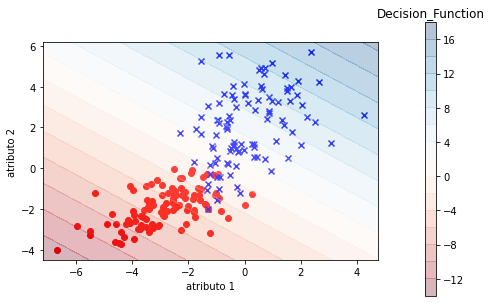

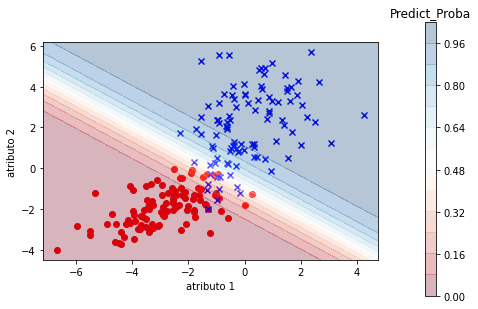

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
cla = LinearDiscriminantAnalysis(store_covariance=True)
cla.fit(X,y)
my_plot_biclassifier(cla,X,y)
plt.title('Decision_Function')
plt.show()

my_plot_biclassifier(cla,X,y,score_type='predict_proba')
plt.title('Predict_Proba')
plt.show()

# Extensión clasificador de medias a k-vecinos más cercanos

- Aunque el clasificador de medias puede entenderse como una extensión Bayesiana, en la práctica se suele utilizar el concepto de distance a los K-vecinos más cercanos para determinar la membresia del punto.

- Por ende, si se desea encontrar la etiqueta de un nuevo punto, se determina un radio o número de vecinos de búsqueda, y se utiliza el estimador tipo moda para determinar la etiqueta de salida:

![knn](https://github.com/amalvarezme/AnaliticaDatos/blob/master/3_Clasificacion/knncla.png?raw=1)

- El clasificador por vecinos más cercanos ([KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) permite codificar nolinealidades y es flexible, no obstante, dado que depende de la distancia entre muestras, puede ser poco escalable a grandes cantidades de instancias.

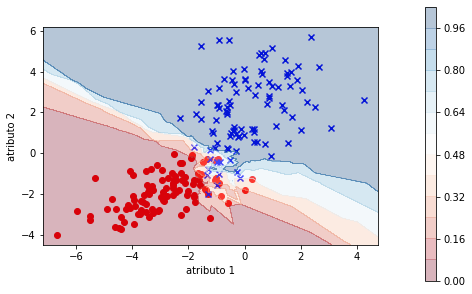

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
cla = KNeighborsClassifier(n_neighbors=5)# el hiperparámetro número de vecinos debe ser sintonizado según la base de datos
cla.fit(X,y)
my_plot_biclassifier(cla,X,y)

# Clasificador Regresor logístico

- Este modelo plantea una relación lineal entre las ganancias de información desde los posteriores $p(A|x)=p(x|A)p(A)$ y $p(B|x)=p(x|B)p(B)$:

$$\log\left(\frac{p(\mathbf{x}|A)p(A)}{p(\mathbf{x}|B)p(B)}\right) = \mathbf{w}^\top\mathbf{x}+b$$

- Teniendo en cuenta que $p(A|x)+p(B|x)=1$, se puede generar una nueva función de decisión, aplicando exp a lado y lado de la expresión:

$$p(A|\mathbf{x})=\frac{1}{1+e^{-(\mathbf{w}^\top\mathbf{x}+b)}} ={\rm{sigmoid}}(\mathbf{w}^\top\mathbf{x}+b)$$

donde la [función sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) se puede entender como un estimador no paramétrico del posterior.

-Asimismo, 

$$p(B|\mathbf{x})=\frac{e^{-(\mathbf{w}^\top\mathbf{x}+b)}}{1+e^{-(\mathbf{w}^\top\mathbf{x}+b)}} $$


# Ejercicio 4

- Demostrar las expresiones anteriores (ver [material de apoyo](https://github.com/amalvarezme/AnaliticaDatos/blob/master/3_Clasificacion/otros/clasificadoresBayes.pdf))


Se anexa [Imagen](https://github.com/dpenagosa/TAREASMINERIA/blob/main/img196.pdf)

- La función de costo del modelo logísto plantea la ganancia de información a partir de los estimadores de los posteriores utilizando sigmoid:

$$L(\mathbf{x}|\mathbf{w},b)=\log\left(\frac{p(A|\mathbf{x})}{p(B|\mathbf{x})}\right)=\log(p(A|\mathbf{x}))-\log(p(B|\mathbf{x}))$$

- Asumiendo muestras independientes e identicamente distribuidas:

$$L(\mathbf{x}|\mathbf{w},b)=\prod_{n=1}^N\log(p(A|\mathbf{x}_n))-\log(p(B|\mathbf{x}_n))$$

- Los parámetros del modelo logístico se encuentra mediante optimización por gradiente descendiente. (Ver [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).



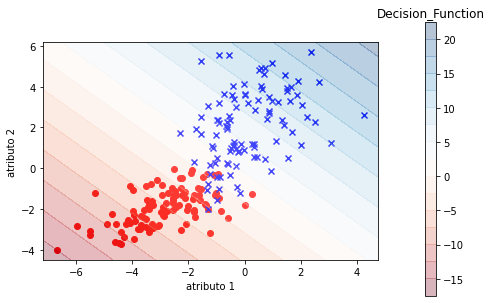

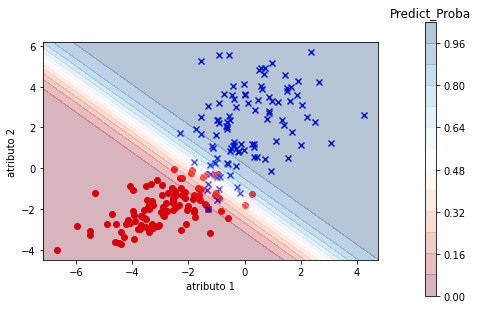

In [ ]:
from sklearn.linear_model import LogisticRegression
cla = LogisticRegression()
cla.fit(X,y)
my_plot_biclassifier(cla,X,y)
plt.title('Decision_Function')
plt.show()

my_plot_biclassifier(cla,X,y,score_type='predict_proba')
plt.title('Predict_Proba')
plt.show()

# Ejercicio 5

- Realice una comparación gráfica utilizando el método `my_plot_biclassifier` de los clasificadores vistos en este cuaderno sobre la base de datos [half moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html). Discuta sobre las fronteras estimadas por cada modelo.

In [ ]:
#Ayuda de código
from sklearn.datasets import make_moons
N = 200
X,y = make_moons(N,noise=0.2)#las etiquetas en y valen 0 o 1
#se ajustan etiqueta a valores -1 y +1 según método definido para visualizar fronteras
y[y==0] = -1

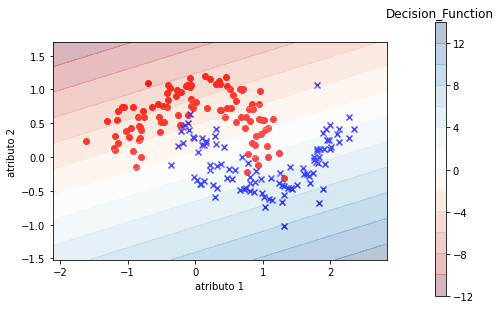

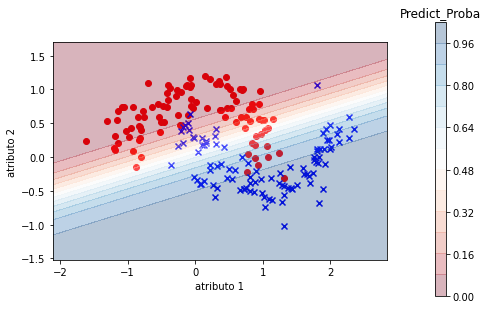

In [ ]:
#clasificador naive bayes
cla = LinearDiscriminantAnalysis()
cla.fit(X,y)
my_plot_biclassifier(cla,X,y)

plt.title('Decision_Function')
plt.show()

my_plot_biclassifier(cla,X,y,score_type='predict_proba')
plt.title('Predict_Proba')
plt.show()

CUADRÁTICO

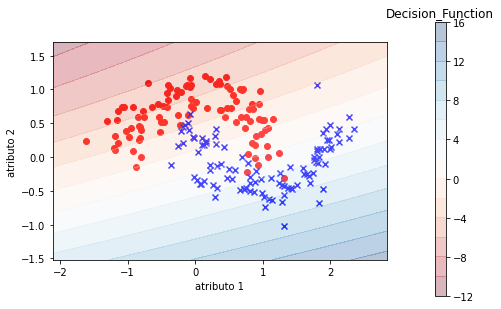

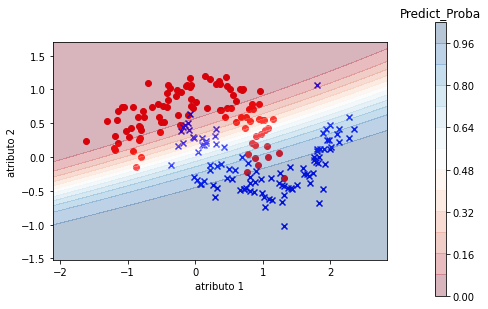

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
cla = QuadraticDiscriminantAnalysis(store_covariance=True) #se obliga a guardar las matrices de cov
cla.fit(X,y)
my_plot_biclassifier(cla,X,y)
plt.title('Decision_Function')
plt.show()

my_plot_biclassifier(cla,X,y,score_type='predict_proba')
plt.title('Predict_Proba')
plt.show()



LINEAL

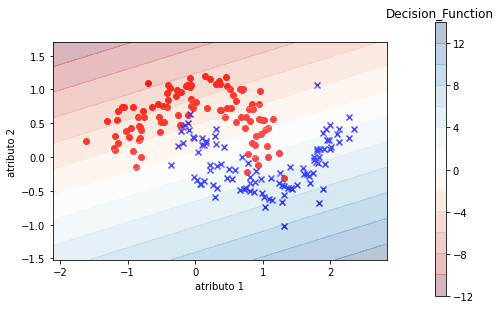

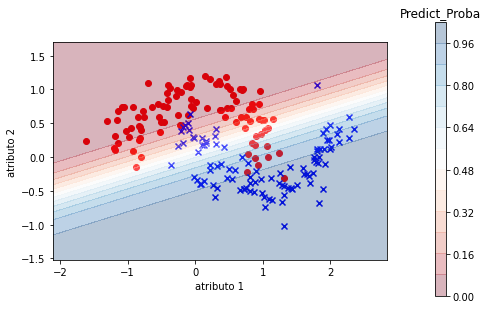

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
cla = LinearDiscriminantAnalysis(store_covariance=True)
cla.fit(X,y)
my_plot_biclassifier(cla,X,y)
plt.title('Decision_Function')
plt.show()

my_plot_biclassifier(cla,X,y,score_type='predict_proba')
plt.title('Predict_Proba')
plt.show()

K MEDIAS

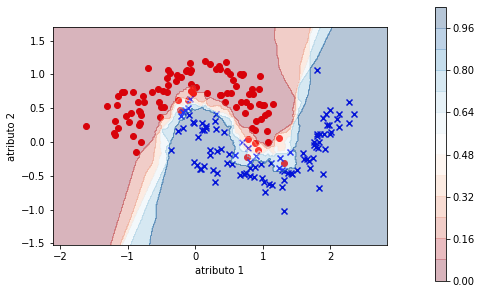

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
cla = KNeighborsClassifier(n_neighbors=5)# el hiperparámetro número de vecinos debe ser sintonizado según la base de datos
cla.fit(X,y)
my_plot_biclassifier(cla,X,y)

Con los resultados obtenidos se observa que el clasificador de naives no logra separar de manera correcta los grupos, lo mismo ocurre con el cuadrático, dividen con lineas, lo que no se ajusta al caso particular.
Mientras que el kmedias tiene la mejor clasificación aunque algunos datos rojos, se clasifican mal, solo unos pocos datos, el método sigue siendo el mejor, visualmente.